# HW3: Explore and Exploit for Arm-Bandit Problem

In [16]:
import numpy as np
import matplotlib.pyplot as plt

## Epsilon-Greedy 演算法實作

In [17]:
class EpsilonGreedy:
    def __init__(self, n_arms: int, epsilon: float):
        """
        :param n_arms: 臂數
        :param epsilon: 探索率 ε (0 <= ε <= 1)
        """
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms, dtype=int)   # 每隻臂被拉的次數
        self.values = np.zeros(n_arms, dtype=float) # 每隻臂的平均回報估計

    def select_arm(self) -> int:
        """根據 ε-Greedy 策略選擇一隻臂。"""
        if np.random.rand() < self.epsilon:
            # 探索：隨機選一隻臂
            return np.random.randint(self.n_arms)
        else:
            # 利用：選擇當前估計值最高的臂
            return int(np.argmax(self.values))

    def update(self, chosen_arm: int, reward: float):
        """根據拉到的回報更新該臂的計數和平均回報估計。"""
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        # 增量更新平均值
        self.values[chosen_arm] += (reward - value) / n


## UCB 演算法實作

In [18]:
class UCB1:
    def __init__(self, n_arms: int):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms, dtype=int)
        self.values = np.zeros(n_arms, dtype=float)
        self.total_counts = 0

    def select_arm(self) -> int:
        # 每隻臂至少拉一次
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        # 計算 UCB 指數
        ucb_values = self.values + np.sqrt((2 * np.log(self.total_counts)) / self.counts)
        return int(np.argmax(ucb_values))

    def update(self, chosen_arm: int, reward: float):
        self.counts[chosen_arm] += 1
        self.total_counts += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] += (reward - value) / n

## SoftMax 演算法實作

In [19]:
class SoftmaxBandit:
    def __init__(self, n_arms: int, temperature: float):
        self.n_arms = n_arms
        self.temperature = temperature
        self.counts = np.zeros(n_arms, dtype=int)
        self.values = np.zeros(n_arms, dtype=float)

    def select_arm(self) -> int:
        # 計算 Softmax 機率
        exp_vals = np.exp(self.values / self.temperature)
        probs = exp_vals / np.sum(exp_vals)
        return int(np.random.choice(self.n_arms, p=probs))

    def update(self, chosen_arm: int, reward: float):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] += (reward - value) / n

## Thompson Sampling 演算法實作

In [20]:
class ThompsonSampling:
    def __init__(self, n_arms: int):
        self.n_arms = n_arms
        self.alphas = np.ones(n_arms, dtype=float)
        self.betas = np.ones(n_arms, dtype=float)

    def select_arm(self) -> int:
        # 從 Beta 分布抽樣
        samples = np.random.beta(self.alphas, self.betas)
        return int(np.argmax(samples))

    def update(self, chosen_arm: int, reward: float):
        # 假設 reward 為二元 (0 or 1)
        self.alphas[chosen_arm] += reward
        self.betas[chosen_arm] += 1 - reward

In [25]:
def simulate(policy, n_arms: int, n_rounds: int, binary: bool = False):
    """
    :param policy: bandit policy instance with select_arm() and update()
    :param n_arms: number of arms
    :param n_rounds: simulation length
    :param binary: if True, rewards are Bernoulli(p) with p ~ Uniform[0,1]; 
                   else rewards are Gaussian with mean ~ N(0,1)
    """
    if binary:
        true_means = np.random.rand(n_arms)             # treat as success probabilities
    else:
        true_means = np.random.randn(n_arms)            # treat as Gaussian means
    rewards = np.zeros(n_rounds)
    for t in range(n_rounds):
        arm = policy.select_arm()
        if binary:
            reward = 1 if np.random.rand() < true_means[arm] else 0
        else:
            reward = np.random.randn() + true_means[arm]
        policy.update(arm, reward)
        rewards[t] = reward
    return np.cumsum(rewards)

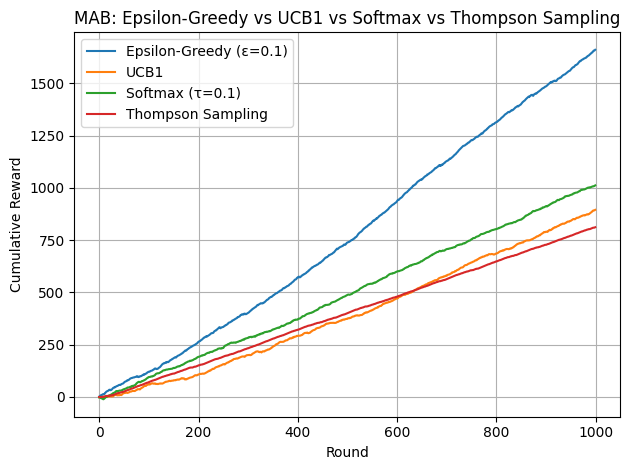

In [26]:
if __name__ == "__main__":
    N_ARMS = 10
    N_ROUNDS = 1000

    eg = EpsilonGreedy(N_ARMS, epsilon=0.1)
    ucb = UCB1(N_ARMS)
    sm = SoftmaxBandit(N_ARMS, temperature=0.1)
    ts = ThompsonSampling(N_ARMS)

    eg_rewards = simulate(eg, N_ARMS, N_ROUNDS)
    ucb_rewards = simulate(ucb, N_ARMS, N_ROUNDS)
    sm_rewards = simulate(sm, N_ARMS, N_ROUNDS)
    ts_rewards = simulate(ts, N_ARMS, N_ROUNDS, binary=True)

    plt.plot(eg_rewards, label="Epsilon-Greedy (ε=0.1)")
    plt.plot(ucb_rewards, label="UCB1")
    plt.plot(sm_rewards, label="Softmax (τ=0.1)")
    plt.plot(ts_rewards, label="Thompson Sampling")
    plt.xlabel("Round")
    plt.ylabel("Cumulative Reward")
    plt.title("MAB: Epsilon-Greedy vs UCB1 vs Softmax vs Thompson Sampling")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
